In [1]:
import torch
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

#NOTE: Last tested working diffusers version is diffusers==0.4.1, https://github.com/huggingface/diffusers/releases/tag/v0.4.1

In [2]:
#Init CLIP tokenizer and model
model_path_clip = "openai/clip-vit-large-patch14"
clip_tokenizer = CLIPTokenizer.from_pretrained(model_path_clip)
clip_model = CLIPModel.from_pretrained(model_path_clip, torch_dtype=torch.float16)
clip = clip_model.text_model

#Init diffusion model
auth_token = True #Replace this with huggingface auth token as a string if model is not already downloaded
model_path_diffusion = "CompVis/stable-diffusion-v1-4"
unet = UNet2DConditionModel.from_pretrained(model_path_diffusion, subfolder="unet", use_auth_token=auth_token, revision="fp16", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained(model_path_diffusion, subfolder="vae", use_auth_token=auth_token, revision="fp16", torch_dtype=torch.float16)

#Move to GPU
device = "cuda"
unet.to(device)
vae.to(device)
clip.to(device)
print("Loaded all models")

Loaded all models


In [3]:
import numpy as np
import random
from PIL import Image
from diffusers import LMSDiscreteScheduler, DDIMScheduler
from tqdm.auto import tqdm
from torch import autocast
from difflib import SequenceMatcher

def init_attention_weights(weight_tuples):
    tokens_length = clip_tokenizer.model_max_length
    weights = torch.ones(tokens_length)
    
    for i, w in weight_tuples:
        if i < tokens_length and i >= 0:
            weights[i] = w
    
    
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice_weights = weights.to(device)
        if module_name == "CrossAttention" and "attn1" in name:
            module.last_attn_slice_weights = None
    

def init_attention_edit(tokens, tokens_edit):
    tokens_length = clip_tokenizer.model_max_length
    mask = torch.zeros(tokens_length)
    indices_target = torch.arange(tokens_length, dtype=torch.long)
    indices = torch.zeros(tokens_length, dtype=torch.long)

    tokens = tokens.input_ids.numpy()[0]
    tokens_edit = tokens_edit.input_ids.numpy()[0]
    
    for name, a0, a1, b0, b1 in SequenceMatcher(None, tokens, tokens_edit).get_opcodes():
        if b0 < tokens_length:
            if name == "equal" or (name == "replace" and a1-a0 == b1-b0):
                mask[b0:b1] = 1
                indices[b0:b1] = indices_target[a0:a1]

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice_mask = mask.to(device)
            module.last_attn_slice_indices = indices.to(device)
        if module_name == "CrossAttention" and "attn1" in name:
            module.last_attn_slice_mask = None
            module.last_attn_slice_indices = None


def init_attention_func():
    #ORIGINAL SOURCE CODE: https://github.com/huggingface/diffusers/blob/91ddd2a25b848df0fa1262d4f1cd98c7ccb87750/src/diffusers/models/attention.py#L276
    def new_attention(self, query, key, value):
        # TODO: use baddbmm for better performance
        attention_scores = torch.matmul(query, key.transpose(-1, -2)) * self.scale
        attn_slice = attention_scores.softmax(dim=-1)
        # compute attention output
        
        if self.use_last_attn_slice:
            if self.last_attn_slice_mask is not None:
                new_attn_slice = torch.index_select(self.last_attn_slice, -1, self.last_attn_slice_indices)
                attn_slice = attn_slice * (1 - self.last_attn_slice_mask) + new_attn_slice * self.last_attn_slice_mask
            else:
                attn_slice = self.last_attn_slice

            self.use_last_attn_slice = False

        if self.save_last_attn_slice:
            self.last_attn_slice = attn_slice
            self.save_last_attn_slice = False

        if self.use_last_attn_weights and self.last_attn_slice_weights is not None:
            attn_slice = attn_slice * self.last_attn_slice_weights
            self.use_last_attn_weights = False
        
        hidden_states = torch.matmul(attn_slice, value)
        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states
    
    def new_sliced_attention(self, query, key, value, sequence_length, dim):
        
        batch_size_attention = query.shape[0]
        hidden_states = torch.zeros(
            (batch_size_attention, sequence_length, dim // self.heads), device=query.device, dtype=query.dtype
        )
        slice_size = self._slice_size if self._slice_size is not None else hidden_states.shape[0]
        for i in range(hidden_states.shape[0] // slice_size):
            start_idx = i * slice_size
            end_idx = (i + 1) * slice_size
            attn_slice = (
                torch.matmul(query[start_idx:end_idx], key[start_idx:end_idx].transpose(1, 2)) * self.scale
            )  # TODO: use baddbmm for better performance
            attn_slice = attn_slice.softmax(dim=-1)
            
            if self.use_last_attn_slice:
                if self.last_attn_slice_mask is not None:
                    new_attn_slice = torch.index_select(self.last_attn_slice, -1, self.last_attn_slice_indices)
                    attn_slice = attn_slice * (1 - self.last_attn_slice_mask) + new_attn_slice * self.last_attn_slice_mask
                else:
                    attn_slice = self.last_attn_slice
                
                self.use_last_attn_slice = False
                    
            if self.save_last_attn_slice:
                self.last_attn_slice = attn_slice
                self.save_last_attn_slice = False
                
            if self.use_last_attn_weights and self.last_attn_slice_weights is not None:
                attn_slice = attn_slice * self.last_attn_slice_weights
                self.use_last_attn_weights = False
            
            attn_slice = torch.matmul(attn_slice, value[start_idx:end_idx])

            hidden_states[start_idx:end_idx] = attn_slice

        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention":
            module.last_attn_slice = None
            module.use_last_attn_slice = False
            module.use_last_attn_weights = False
            module.save_last_attn_slice = False
            module._sliced_attention = new_sliced_attention.__get__(module, type(module))
            module._attention = new_attention.__get__(module, type(module))
            
def use_last_tokens_attention(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.use_last_attn_slice = use
            
def use_last_tokens_attention_weights(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.use_last_attn_weights = use
            
def use_last_self_attention(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn1" in name:
            module.use_last_attn_slice = use
            
def save_last_tokens_attention(save=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.save_last_attn_slice = save
            
def save_last_self_attention(save=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn1" in name:
            module.save_last_attn_slice = save
            
@torch.no_grad()
def stablediffusion(prompt="", prompt_edit=None, prompt_edit_token_weights=[], init_latents=None, prompt_edit_tokens_start=0.0, prompt_edit_tokens_end=1.0, prompt_edit_spatial_start=0.0, prompt_edit_spatial_end=1.0, guidance_scale=7.5, steps=50, seed=None, width=512, height=512):
    #Change size to multiple of 64 to prevent size mismatches inside model
    if init_latents is not None:
        width = init_latents.shape[-1] * 8
        height = init_latents.shape[-2] * 8
        
    width = width - width % 64
    height = height - height % 64
    
    #If seed is None, randomly select seed from 0 to 2^32-1
    if seed is None: seed = random.randrange(2**32 - 1)
    generator = torch.cuda.manual_seed(seed)
    
    #Set inference timesteps to scheduler
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(steps)
    
    init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
    t_start = 0
    
    #Generate random normal noise
    noise = torch.randn(init_latent.shape, generator=generator, device=device)
    
    #If init_latents is used, initialize noise as init_latent
    if init_latents is not None:
        noise = init_latents
    
    init_latents = noise
    latent = scheduler.add_noise(init_latent, noise, torch.tensor([scheduler.timesteps[t_start]], device=device)).to(device)
        
    #Process clip
    with autocast(device):
        tokens_unconditional = clip_tokenizer("", padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
        embedding_unconditional = clip(tokens_unconditional.input_ids.to(device)).last_hidden_state

        tokens_conditional = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
        embedding_conditional = clip(tokens_conditional.input_ids.to(device)).last_hidden_state

        #Process prompt editing
        if prompt_edit is not None:
            tokens_conditional_edit = clip_tokenizer(prompt_edit, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
            embedding_conditional_edit = clip(tokens_conditional_edit.input_ids.to(device)).last_hidden_state
            
            init_attention_edit(tokens_conditional, tokens_conditional_edit)
            
        init_attention_func()
        init_attention_weights(prompt_edit_token_weights)
            
        timesteps = scheduler.timesteps[t_start:]
        
        for i, t in tqdm(enumerate(timesteps), total=len(timesteps)):
            t_index = t_start + i

            #sigma = scheduler.sigmas[t_index]
            latent_model_input = latent
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            
            #Predict the unconditional noise residual
            noise_pred_uncond = unet(latent_model_input, t, encoder_hidden_states=embedding_unconditional).sample
            
            #Prepare the Cross-Attention layers
            if prompt_edit is not None:
                save_last_tokens_attention()
                save_last_self_attention()
            else:
                #Use weights on non-edited prompt when edit is None
                use_last_tokens_attention_weights()
                
            #Predict the conditional noise residual and save the cross-attention layer activations
            noise_pred_cond = unet(latent_model_input, t, encoder_hidden_states=embedding_conditional).sample
            
            #Edit the Cross-Attention layer activations
            if prompt_edit is not None:
                t_scale = t / scheduler.num_train_timesteps
                if t_scale >= prompt_edit_tokens_start and t_scale <= prompt_edit_tokens_end:
                    use_last_tokens_attention()
                if t_scale >= prompt_edit_spatial_start and t_scale <= prompt_edit_spatial_end:
                    use_last_self_attention()
                    
                #Use weights on edited prompt
                use_last_tokens_attention_weights()

                #Predict the edited conditional noise residual using the cross-attention masks
                noise_pred_cond = unet(latent_model_input, t, encoder_hidden_states=embedding_conditional_edit).sample
                
            #Perform guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
            
            latent = scheduler.step(noise_pred, t_index, latent).prev_sample

        #scale and decode the image latents with vae
        latent = latent / 0.18215
        image = vae.decode(latent.to(vae.dtype)).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image[0] * 255).round().astype("uint8")
    return Image.fromarray(image)


In [4]:
@torch.no_grad()
def inversestablediffusion(init_image, prompt="", guidance_scale=3.0, steps=50, refine_iterations=3, refine_strength=0.9, refine_skip=0.7):
    #Change size to multiple of 64 to prevent size mismatches inside model
    width, height = init_image.size
    width = width - width % 64
    height = height - height % 64
    
    image_width, image_height = init_image.size
    left = (image_width - width)/2
    top = (image_height - height)/2
    right = left + width
    bottom = top + height
    
    init_image = init_image.crop((left, top, right, bottom))
    init_image = np.array(init_image).astype(np.float32) / 255.0 * 2.0 - 1.0
    init_image = torch.from_numpy(init_image[np.newaxis, ...].transpose(0, 3, 1, 2))

    #If there is alpha channel, composite alpha for white, as the diffusion model does not support alpha channel
    if init_image.shape[1] > 3:
        init_image = init_image[:, :3] * init_image[:, 3:] + (1 - init_image[:, 3:])

    #Move image to GPU
    init_image = init_image.to(device)

    train_steps = 1000
    step_ratio = train_steps // steps
    timesteps = torch.from_numpy(np.linspace(0, train_steps - 1, steps + 1, dtype=float)).int().to(device)
    
    betas = torch.linspace(0.00085**0.5, 0.012**0.5, train_steps, dtype=torch.float32) ** 2
    alphas = torch.cumprod(1 - betas, dim=0)
    
    init_step = 0
    
    #Fixed seed such that the vae sampling is deterministic, shouldn't need to be changed by the user...
    generator = torch.cuda.manual_seed(798122)
    
    #Process clip
    with autocast(device):
        init_latent = vae.encode(init_image).latent_dist.sample(generator=generator) * 0.18215
        
        tokens_unconditional = clip_tokenizer("", padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
        embedding_unconditional = clip(tokens_unconditional.input_ids.to(device)).last_hidden_state

        tokens_conditional = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
        embedding_conditional = clip(tokens_conditional.input_ids.to(device)).last_hidden_state
        
        latent = init_latent

        for i in tqdm(range(steps), total=steps):
            t_index = i + init_step
            
            t = timesteps[t_index]
            t1 = timesteps[t_index + 1]
            #Magic number for tless taken from Narnia, used for backwards CFG correction
            tless = t - (t1 - t) * 0.25
            
            ap = alphas[t] ** 0.5
            bp = (1 - alphas[t]) ** 0.5
            ap1 = alphas[t1] ** 0.5
            bp1 = (1 - alphas[t1]) ** 0.5
            
            latent_model_input = latent
            #Predict the unconditional noise residual
            noise_pred_uncond = unet(latent_model_input, t, encoder_hidden_states=embedding_unconditional).sample
            
            #Predict the conditional noise residual and save the cross-attention layer activations
            noise_pred_cond = unet(latent_model_input, t, encoder_hidden_states=embedding_conditional).sample
            
            #Perform guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
            
            #One reverse DDIM step
            px0 = (latent_model_input - bp * noise_pred) / ap
            latent = ap1 * px0 + bp1 * noise_pred
            
            #Initialize loop variables
            latent_refine = latent
            latent_orig = latent_model_input
            min_error = 1e10
            lr = refine_strength
            
            #Finite difference gradient descent method to correct for classifier free guidance, performs best when CFG is high
            #Very slow and unoptimized, might be able to use Newton's method or some other multidimensional root finding method
            if i > (steps * refine_skip):
                for k in range(refine_iterations):
                    #Compute reverse diffusion process to get better prediction for noise at t+1
                    #tless and t are used instead of the "numerically correct" t+1, produces way better results in practice, reason unknown...
                    noise_pred_uncond = unet(latent_refine, tless, encoder_hidden_states=embedding_unconditional).sample
                    noise_pred_cond = unet(latent_refine, t, encoder_hidden_states=embedding_conditional).sample
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
                    
                    #One forward DDIM Step
                    px0 = (latent_refine - bp1 * noise_pred) / ap1
                    latent_refine_orig = ap * px0 + bp * noise_pred
                    
                    #Save latent if error is smaller
                    error = float((latent_orig - latent_refine_orig).abs_().sum())
                    if error < min_error:
                        latent = latent_refine
                        min_error = error

                    #print(k, error)
                    
                    #Break to avoid "overfitting", too low error does not produce good results in practice, why?
                    if min_error < 5:
                        break
                    
                    #"Learning rate" decay if error decrease is too small or negative (dampens oscillations)
                    if (min_error - error) < 1:
                        lr *= 0.9
                    
                    #Finite difference gradient descent
                    latent_refine = latent_refine + (latent_model_input - latent_refine_orig) * lr
                    
            
    return latent

In [5]:
def prompt_token(prompt, index):
    tokens = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True).input_ids[0]
    return clip_tokenizer.decode(tokens[index:index+1])

In [6]:
prompt_token("a photo of a woman with blonde hair", 2)

'photo'

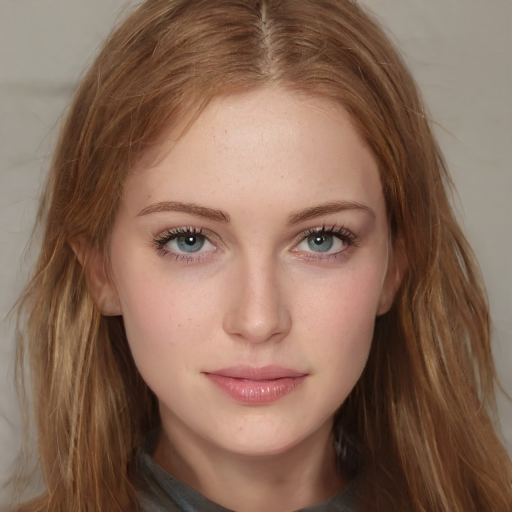

In [7]:
#https://pixabay.com/photos/portrait-woman-model-face-6054910/
input_image = Image.open("portrait.png")
input_image

In [8]:
gen_latents = inversestablediffusion(input_image, "a photo of a woman with blonde hair", refine_iterations=5, guidance_scale=4.0)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

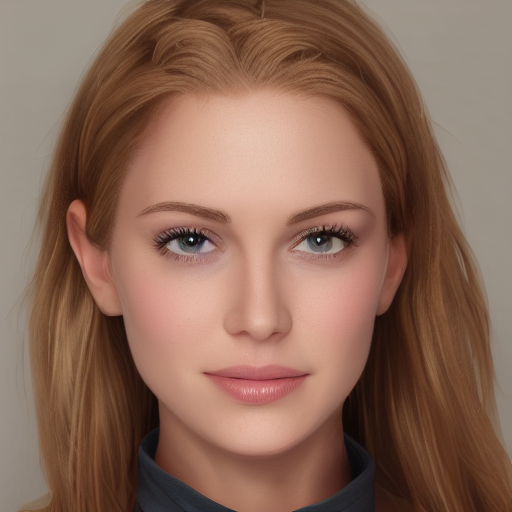

In [9]:
stablediffusion("a photo of a woman with blonde hair", guidance_scale=4.0, init_latents=gen_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

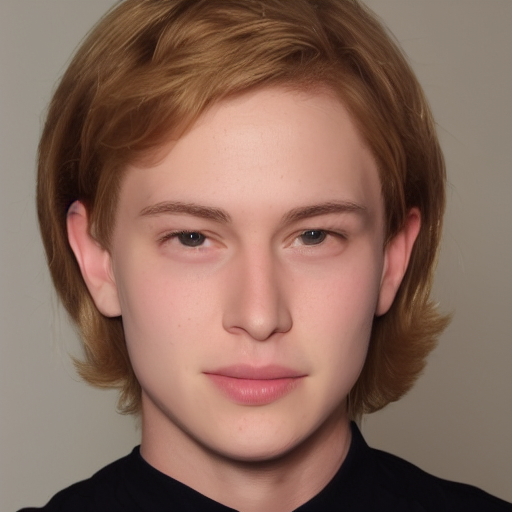

In [10]:
stablediffusion("a photo of a woman with blonde hair", "a photo of a young man with short blonde hair", prompt_edit_spatial_end=0.9, guidance_scale=4.0, init_latents=gen_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

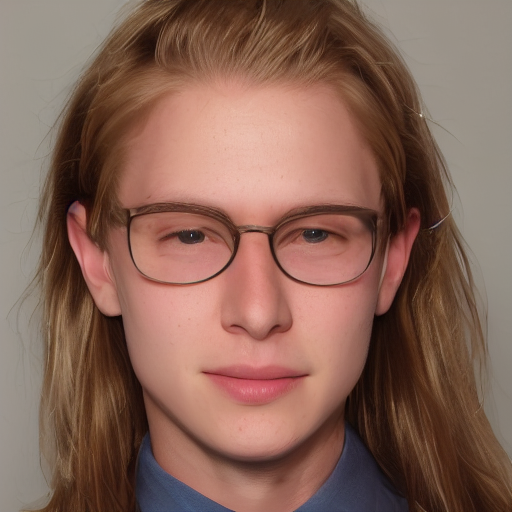

In [11]:
stablediffusion("a photo of a woman with blonde hair", "a photo of a young man with long blonde hair and glasses", guidance_scale=4.0, init_latents=gen_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

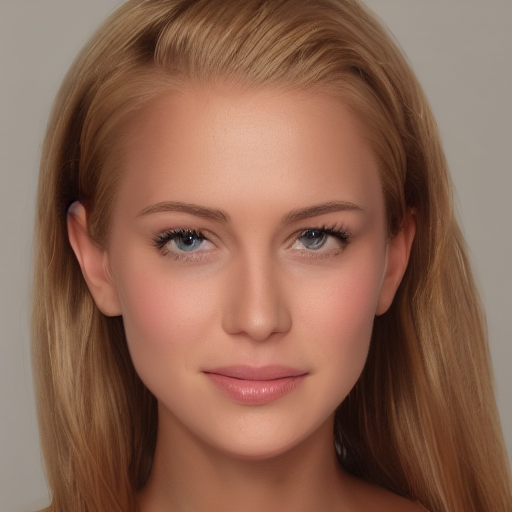

In [12]:
stablediffusion("a photo of a woman with blonde hair", "a photo of a woman with blonde hair, tanned skin", prompt_edit_spatial_end=0.9, guidance_scale=4.0, init_latents=gen_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

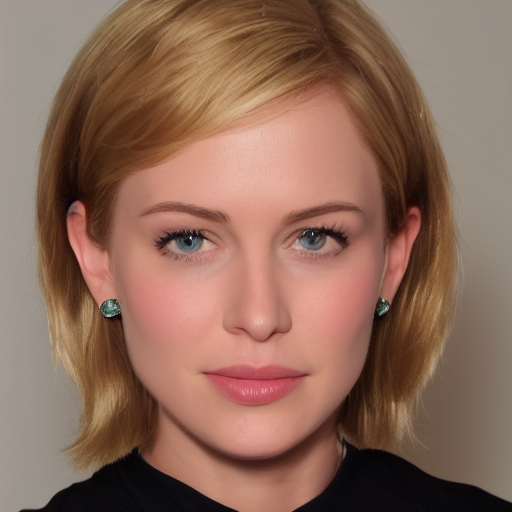

In [13]:
stablediffusion("a photo of a woman with blonde hair", "a photo of a young woman with short blonde hair and earrings, smiling", prompt_edit_token_weights=[(14, -2.5)], prompt_edit_spatial_end=0.9, guidance_scale=4.0, init_latents=gen_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

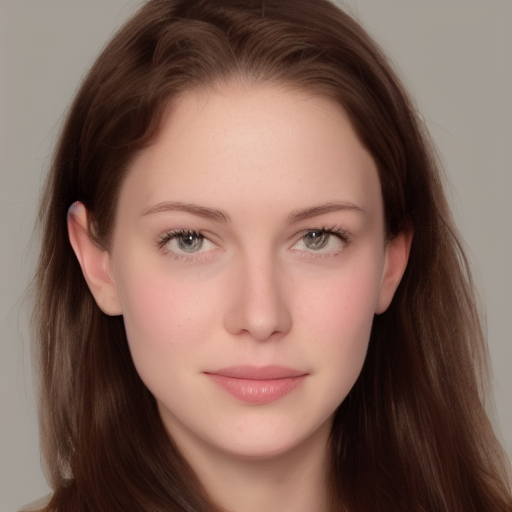

In [14]:
stablediffusion("a photo of a woman with blonde hair", "a photo of a young woman with brown hair, smiling", prompt_edit_token_weights=[(11, -2.5)], guidance_scale=4.0, init_latents=gen_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

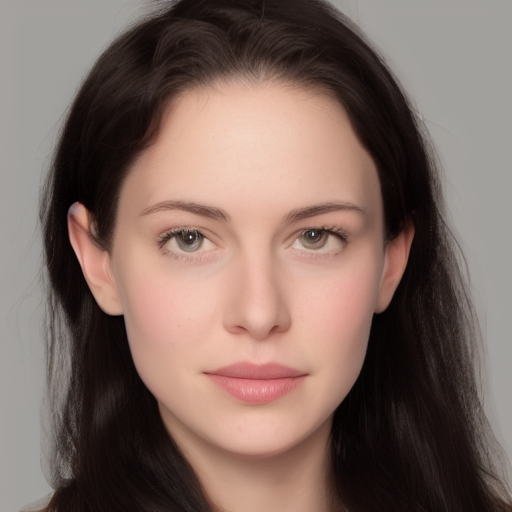

In [15]:
stablediffusion("a photo of a woman with blonde hair", "a photo of a young woman with wavy black hair, smiling, raised eyebrows", prompt_edit_token_weights=[(12, -3), (14, -3)], guidance_scale=4.0, init_latents=gen_latents)

  0%|          | 0/50 [00:00<?, ?it/s]

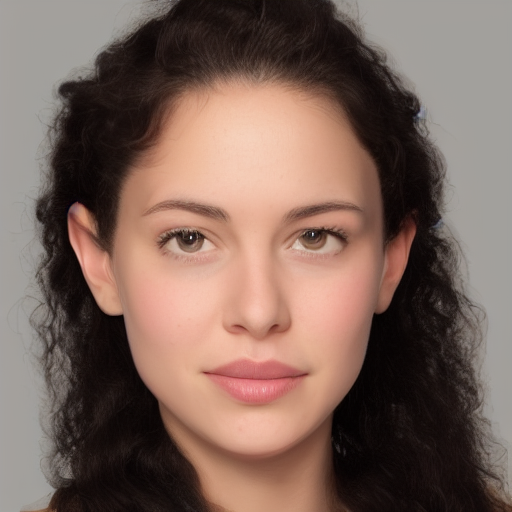

In [16]:
stablediffusion("a photo of a woman with blonde hair", "a photo of a young woman with curly black hair, smiling, raised eyebrows", prompt_edit_token_weights=[(12, -2.5), (14, -3)], init_latents=gen_latents, guidance_scale=4.0)